In [76]:
# Task 1: Load Two Data Sets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_1 = pd.read_csv('DF_1_FAOSTAT_data_en_11-19-2025.csv')
df_2 = pd.read_csv('DF_2_Crop_recommendation.csv')

print(f"DF_1 Shape: {df_1.shape}")
print(f"DF_2 Shape: {df_2.shape}")

DF_1 Shape: (5940, 15)
DF_2 Shape: (2200, 8)


In [77]:
# Task 2: Filter Yield Dataset for Area = India only
df_1_india = df_1[df_1['Area'] == 'India'].copy()
print(f"Filtered Dataset Shape: {df_1_india.shape}")

Filtered Dataset Shape: (5940, 15)


In [78]:
# Task 3: Perform Explosion on Yield Dataset
protected_items = {
    'Apples', 'Bananas', 'Coconuts, in shell', 'Coffee, green', 'Grapes',
    'Jute, raw or retted', 'Lentils, dry', 'Maize (corn)',
    'Mangoes, guavas and mangosteens', 'Oranges', 'Papayas', 'Rice',
    'Seed cotton, unginned', 'Pigeon peas, dry', 'Chick peas, dry',
    'Cantaloupes and other melons', 'Beans, dry', 'Watermelons',
}

def split_items(item):
    text = str(item).strip()
    if text in protected_items:
        return [text]
    parts = [p.strip() for p in text.split(',') if p.strip()]
    return parts or [text]

df_1_india['Item_List'] = df_1_india['Item'].apply(split_items)
df_1_exploded = df_1_india.explode('Item_List').copy()
df_1_exploded['Item'] = df_1_exploded['Item_List'].str.strip()

print(f"After Explosion Shape: {df_1_exploded.shape}")

After Explosion Shape: (8512, 16)


In [79]:
# Task 4: Merge two datasets
target_map = {
    'Apples': 'apple', 'Bananas': 'banana', 'Coconuts, in shell': 'coconut',
    'Coffee, green': 'coffee', 'Grapes': 'grapes', 'Jute, raw or retted': 'jute',
    'Lentils, dry': 'lentil', 'Maize (corn)': 'maize', 'Mangoes, guavas and mangosteens': 'mango',
    'Oranges': 'orange', 'Papayas': 'papaya', 'Rice': 'rice',
    'Seed cotton, unginned': 'cotton', 'Pigeon peas, dry': 'pigeonpeas',
    'Chick peas, dry': 'chickpea', 'Cantaloupes and other melons': 'muskmelon',
    'Beans, dry': 'kidneybeans', 'Watermelons': 'watermelon'
}

map_lower = {k.lower(): v for k, v in target_map.items()}
df_1_exploded['merge_key'] = df_1_exploded['Item'].str.strip().str.lower().map(map_lower)

synonyms = {
    'apples': 'apple', 'grape': 'grapes', 'mangoe': 'mango',
    'seed cotton': 'cotton', 'pigeon pea': 'pigeonpeas', 'pigeonpeas': 'pigeonpeas',
    'chick pea': 'chickpea', 'cantaloupes and other melon': 'muskmelon', 'melon': 'muskmelon',
    'muskmelon': 'muskmelon', 'beans': 'kidneybeans', 'bean': 'kidneybeans',
    'watermelons': 'watermelon', 'coconut': 'coconut', 'coconuts': 'coconut',
    'coocnut': 'coconut', 'cantaloupes': 'muskmelon', 'cantaloupe': 'muskmelon', 'jite': 'jute'
}
df_2['merge_key'] = df_2['label'].str.strip().str.lower().replace(synonyms)

merged_df = pd.merge(df_1_exploded.dropna(subset=['merge_key']), df_2, on='merge_key', how='inner')

print(f"Merged Dataset Shape: {merged_df.shape}")
print(f"Unique Crops: {len(merged_df['label'].unique())}")

Merged Dataset Shape: (129600, 25)
Unique Crops: 18


In [80]:
# Task 5: Keep only specific columns
cols_to_keep = ['Element', 'Value', 'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']
available_cols = [c for c in cols_to_keep if c in merged_df.columns]
final_df = merged_df[available_cols].copy()

print(f"Final Dataset Shape: {final_df.shape}")

Final Dataset Shape: (129600, 10)


In [81]:
# Task 6: Keep only rows where Element is 'Production'
final_df = final_df[final_df['Element'] == 'Production']

In [82]:
# Task 7: Remove Column 'Element'
final_df.drop(columns=['Element'], inplace=True)

Final Dataset Shape: (42600, 9)


C:\Users\rahul\AppData\Local\Temp\ipykernel_29792\3862229849.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df_clean = final_df.groupby('label', group_keys=False).apply(remove_outliers_per_group)


Unique Crops: 18


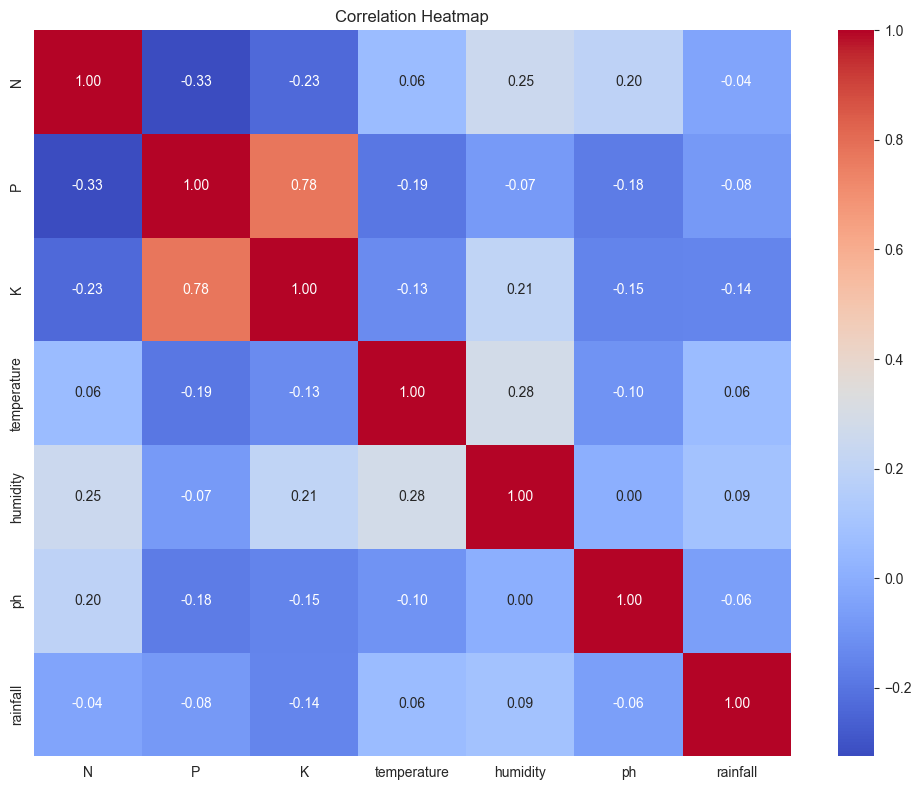

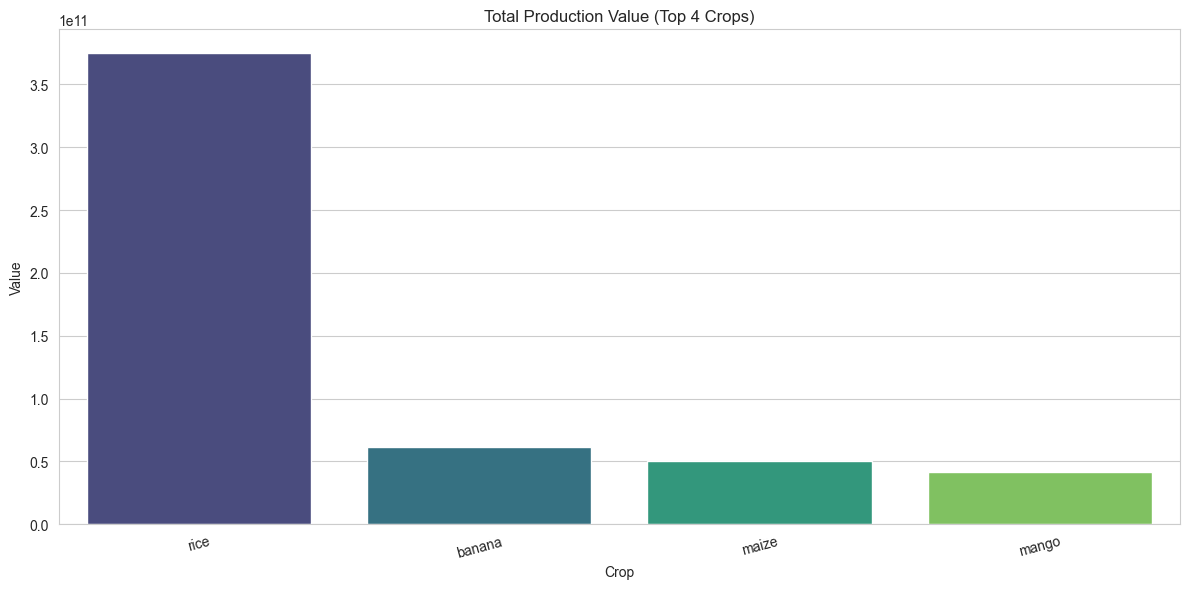

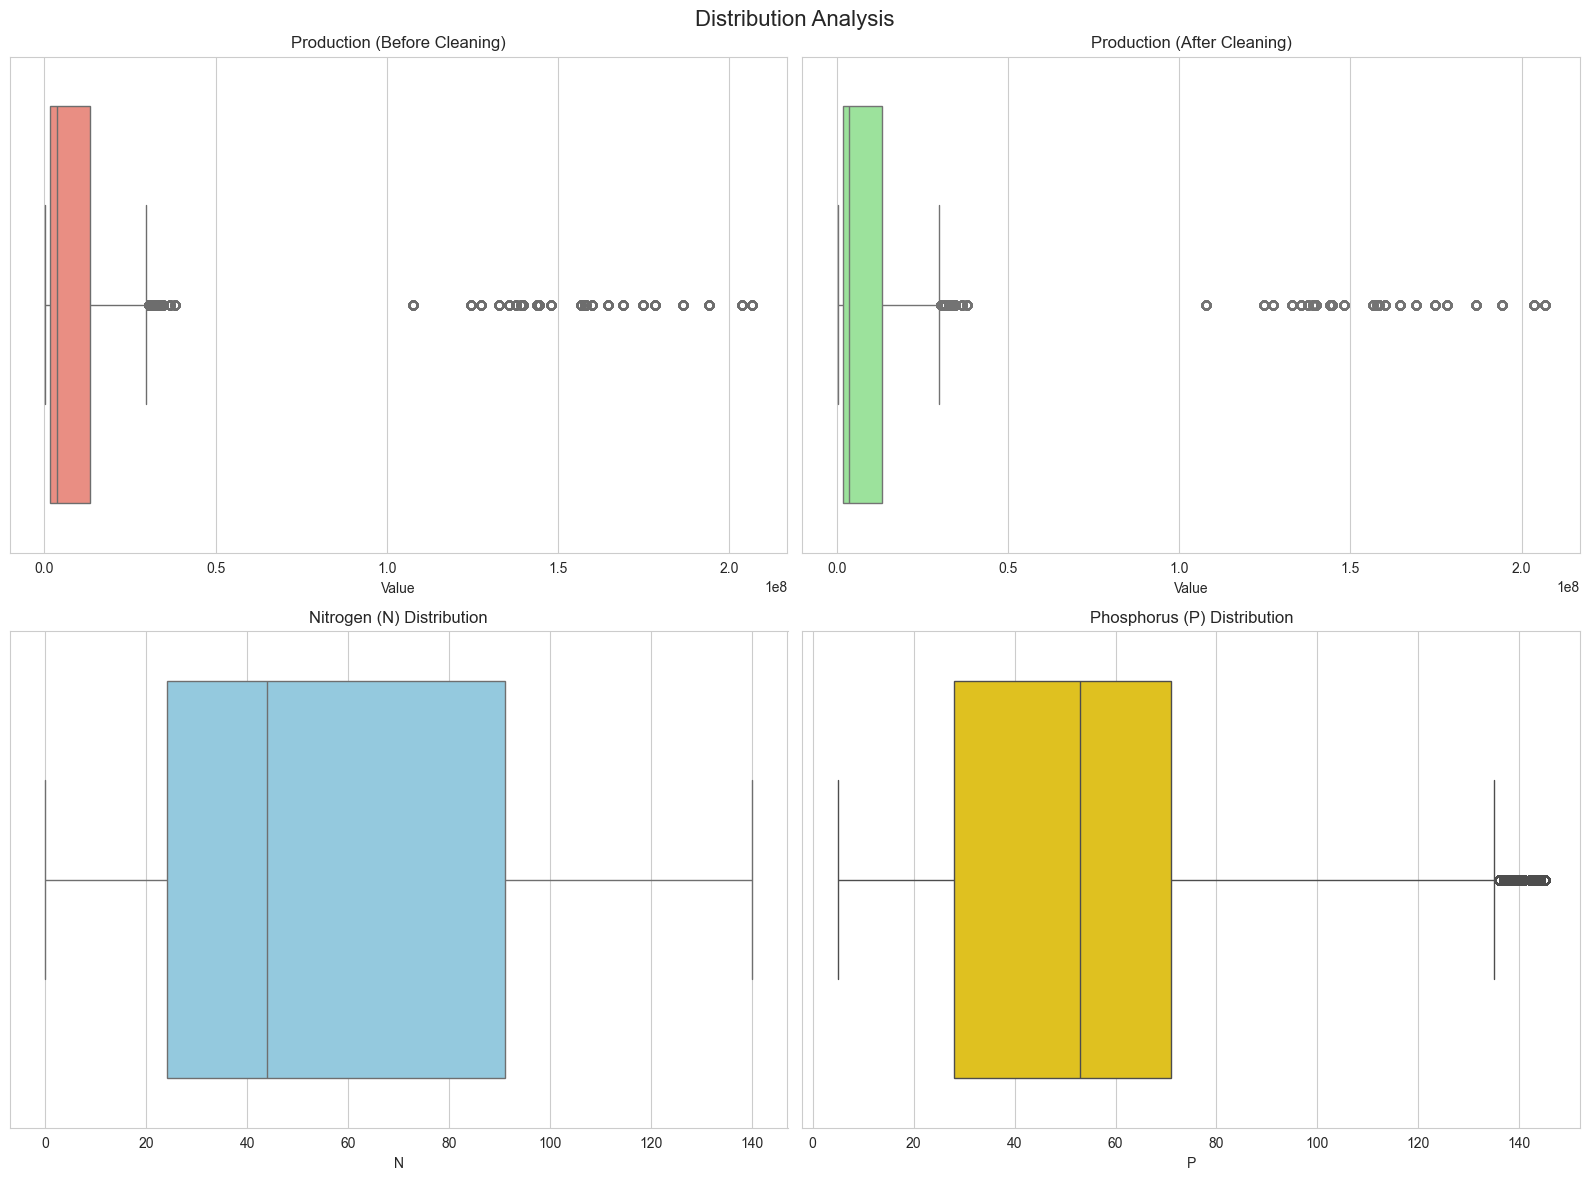

In [83]:
# Task 8: Complete EDA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

final_df.dropna(inplace=True)
final_df.drop_duplicates(inplace=True)

numeric_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

def remove_outliers_per_group(group):
    outlier_counts = pd.Series([0] * len(group), index=group.index)
    for col in numeric_cols:
        Q1 = group[col].quantile(0.25)
        Q3 = group[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 2.5 * IQR
        upper = Q3 + 2.5 * IQR
        outlier_counts += ((group[col] < lower) | (group[col] > upper)).astype(int)
    return group[outlier_counts < 3]

final_df_clean = final_df.groupby('label', group_keys=False).apply(remove_outliers_per_group)

print(f"Final Dataset Shape: {final_df_clean.shape}")
print(f"Unique Crops: {len(final_df_clean['label'].unique())}")

sns.set_style("whitegrid")

plt.figure(figsize=(10, 8))
sns.heatmap(final_df_clean[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

total_by_crop = final_df_clean.groupby('label')['Value'].sum().sort_values(ascending=False)
top4_labels = total_by_crop.head(4).index
plt.figure(figsize=(12, 6))
sns.barplot(x=top4_labels, y=total_by_crop.loc[top4_labels], hue=top4_labels, legend=False, palette="viridis")
plt.title("Total Production Value (Top 4 Crops)")
plt.xlabel("Crop")
plt.ylabel("Value")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution Analysis', fontsize=16)
axes = axes.flatten()

sns.boxplot(x=final_df['Value'], ax=axes[0], color='salmon')
axes[0].set_title('Production (Before Cleaning)')
axes[0].set_xlabel('Value')

sns.boxplot(x=final_df_clean['Value'], ax=axes[1], color='lightgreen')
axes[1].set_title('Production (After Cleaning)')
axes[1].set_xlabel('Value')

sns.boxplot(x=final_df_clean['N'], ax=axes[2], color='skyblue')
axes[2].set_title('Nitrogen (N) Distribution')

sns.boxplot(x=final_df_clean['P'], ax=axes[3], color='gold')
axes[3].set_title('Phosphorus (P) Distribution')

plt.tight_layout()
plt.show()

In [84]:
# Task 9: Data Splitting and Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

final_df_clean.dropna(inplace=True)

target_df = final_df_clean.copy()
X = target_df[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']]
y = target_df['Value']

le = LabelEncoder()
X['label_encoded'] = le.fit_transform(X['label'])
X = X.drop('label', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
numeric_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print(f"Training Data: {X_train.shape}")
print(f"Testing Data: {X_test.shape}")

Training Data: (34080, 8)
Testing Data: (8520, 8)


In [85]:
# Task 10: Training 3 Models (Regression)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
import numpy as np
import time

# Initialize regression models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Train and evaluate
best_test_r2 = float('-inf')
best_model_name = ""
trained_models = {}
results = []

for name, model in models.items():
    print(f"Training {name}...", end=" ")
    start_time = time.time()
    
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)
    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    
    duration = time.time() - start_time
    
    print(f"Done ({duration:.2f}s)")
    print(f"  Training R²: {train_r2:.4f} | MAE: {train_mae:.2f} | RMSE: {train_rmse:.2f}")
    print(f"  Testing R²:  {test_r2:.4f} | MAE: {test_mae:.2f} | RMSE: {test_rmse:.2f}")
    
    results.append({
        'Model': name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse
    })
    
    if test_r2 > best_test_r2:
        best_test_r2 = test_r2
        best_model_name = name

# Cross-validation
print("\nCross-Validation Analysis (5-fold CV):")
for name, model in trained_models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print(f"{name}:")
    print(f"  CV Mean R²: {cv_scores.mean():.4f}")
    print(f"  CV Std:     {cv_scores.std():.4f}")

# Summary
print("\nModel Performance Summary:")
for result in results:
    print(f"{result['Model']:20s} | Train R²: {result['Train_R2']:6.4f} | Test R²: {result['Test_R2']:6.4f}")
    print(f"{'':20s} | Train MAE: {result['Train_MAE']:8.2f} | Test MAE: {result['Test_MAE']:8.2f}")

print(f"\nBest Model: {best_model_name}")
print(f"Best Test R²: {best_test_r2:.4f}")

Training Linear Regression... Done (0.02s)
  Training R²: 0.4328 | MAE: 19268289.29 | RMSE: 27086612.28
  Testing R²:  0.4128 | MAE: 19054516.95 | RMSE: 26839441.74
Training Random Forest... Done (2.81s)
  Training R²: 0.9663 | MAE: 2856859.74 | RMSE: 6606365.82
  Testing R²:  0.9606 | MAE: 2965681.37 | RMSE: 6952768.92
Training XGBoost... Done (0.17s)
  Training R²: 0.9663 | MAE: 2856321.64 | RMSE: 6602952.85
  Testing R²:  0.9607 | MAE: 2951439.44 | RMSE: 6943064.59

Cross-Validation Analysis (5-fold CV):
Linear Regression:
  CV Mean R²: 0.4317
  CV Std:     0.0165
Random Forest:
  CV Mean R²: 0.9619
  CV Std:     0.0020
XGBoost:
  CV Mean R²: 0.9620
  CV Std:     0.0020

Model Performance Summary:
Linear Regression    | Train R²: 0.4328 | Test R²: 0.4128
                     | Train MAE: 19268289.29 | Test MAE: 19054516.95
Random Forest        | Train R²: 0.9663 | Test R²: 0.9606
                     | Train MAE: 2856859.74 | Test MAE: 2965681.37
XGBoost              | Train R²: 0.9

In [86]:
# Task 11: Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

print(f"Hyperparameter Tuning: {best_model_name}")

# Define parameter grid
if best_model_name == "Random Forest":
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    base_model = RandomForestRegressor(random_state=42)
elif best_model_name == "XGBoost":
    param_grid = {
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.2],
        'max_depth': [3, 5]
    }
    base_model = XGBRegressor(random_state=42)
else:
    param_grid = {'fit_intercept': [True, False]}
    base_model = LinearRegression()

# Grid search
print("Running grid search...")
grid_search = GridSearchCV(base_model, param_grid, cv=3, verbose=0, n_jobs=1, scoring='r2')
grid_search.fit(X_train, y_train)

# Get best model
final_model = grid_search.best_estimator_

# Retrain the model with best parameters on full training data
print("Retraining model with best parameters...")
final_model.fit(X_train, y_train)

# Calculate metrics after tuning
tuned_train_pred = final_model.predict(X_train)
tuned_test_pred = final_model.predict(X_test)
tuned_train_r2 = r2_score(y_train, tuned_train_pred)
tuned_test_r2 = r2_score(y_test, tuned_test_pred)
tuned_train_mae = mean_absolute_error(y_train, tuned_train_pred)
tuned_test_mae = mean_absolute_error(y_test, tuned_test_pred)
tuned_train_rmse = np.sqrt(mean_squared_error(y_train, tuned_train_pred))
tuned_test_rmse = np.sqrt(mean_squared_error(y_test, tuned_test_pred))

# Before tuning metrics
before_train_pred = trained_models[best_model_name].predict(X_train)
before_test_pred = trained_models[best_model_name].predict(X_test)
before_train_r2 = r2_score(y_train, before_train_pred)
before_test_r2 = r2_score(y_test, before_test_pred)
before_train_mae = mean_absolute_error(y_train, before_train_pred)
before_test_mae = mean_absolute_error(y_test, before_test_pred)
before_train_rmse = np.sqrt(mean_squared_error(y_train, before_train_pred))
before_test_rmse = np.sqrt(mean_squared_error(y_test, before_test_pred))

print(f"Best Parameters: {grid_search.best_params_}")
print(f"\nBefore Tuning:")
print(f"  Training R²: {before_train_r2:.4f} | MAE: {before_train_mae:.2f} | RMSE: {before_train_rmse:.2f}")
print(f"  Testing R²:  {before_test_r2:.4f} | MAE: {before_test_mae:.2f} | RMSE: {before_test_rmse:.2f}")
print(f"\nAfter Tuning (Retrained):")
print(f"  Training R²: {tuned_train_r2:.4f} | MAE: {tuned_train_mae:.2f} | RMSE: {tuned_train_rmse:.2f}")
print(f"  Testing R²:  {tuned_test_r2:.4f} | MAE: {tuned_test_mae:.2f} | RMSE: {tuned_test_rmse:.2f}")

Hyperparameter Tuning: XGBoost
Running grid search...
Retraining model with best parameters...
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}

Before Tuning:
  Training R²: 0.9663 | MAE: 2856321.64 | RMSE: 6602952.85
  Testing R²:  0.9607 | MAE: 2951439.44 | RMSE: 6943064.59

After Tuning (Retrained):
  Training R²: 0.9656 | MAE: 3029201.19 | RMSE: 6668329.17
  Testing R²:  0.9633 | MAE: 3002383.08 | RMSE: 6712666.13


Best Model: XGBoost
Training R²: 0.9656 (96.56%) | MAE: 3029201.19 | RMSE: 6668329.17
Testing R²:  0.9633 (96.33%) | MAE: 3002383.08 | RMSE: 6712666.13

Model, encoder, and scaler saved successfully.


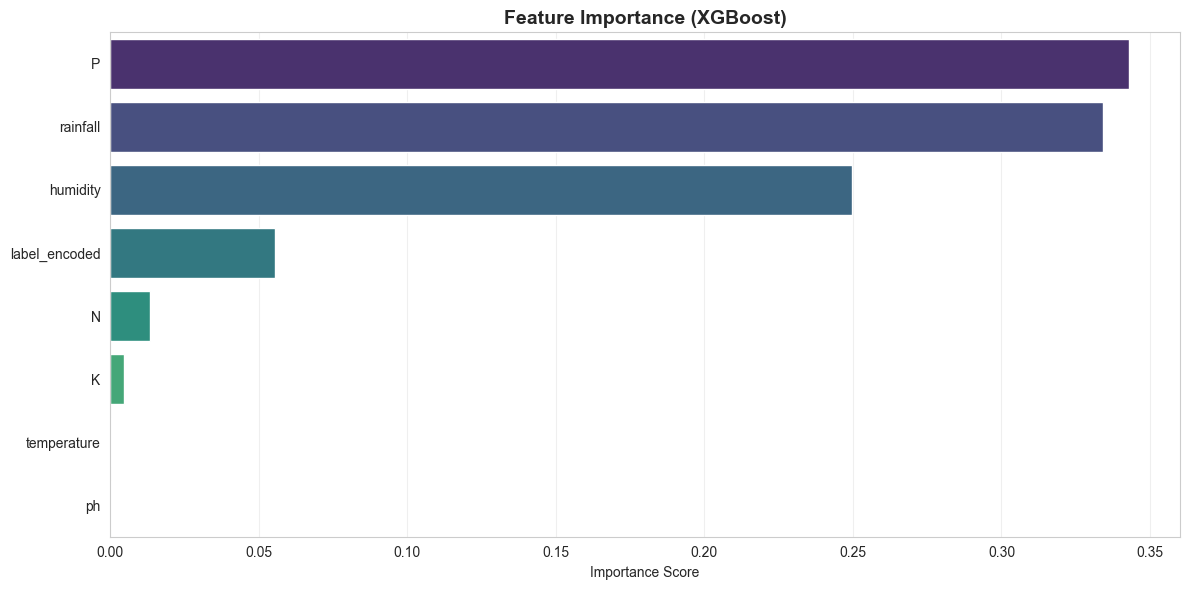

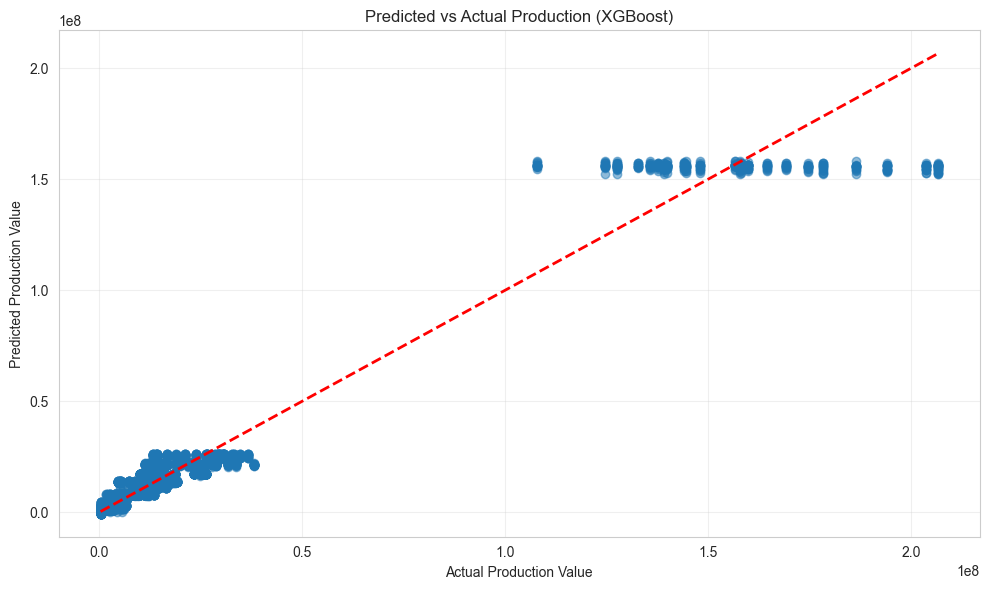

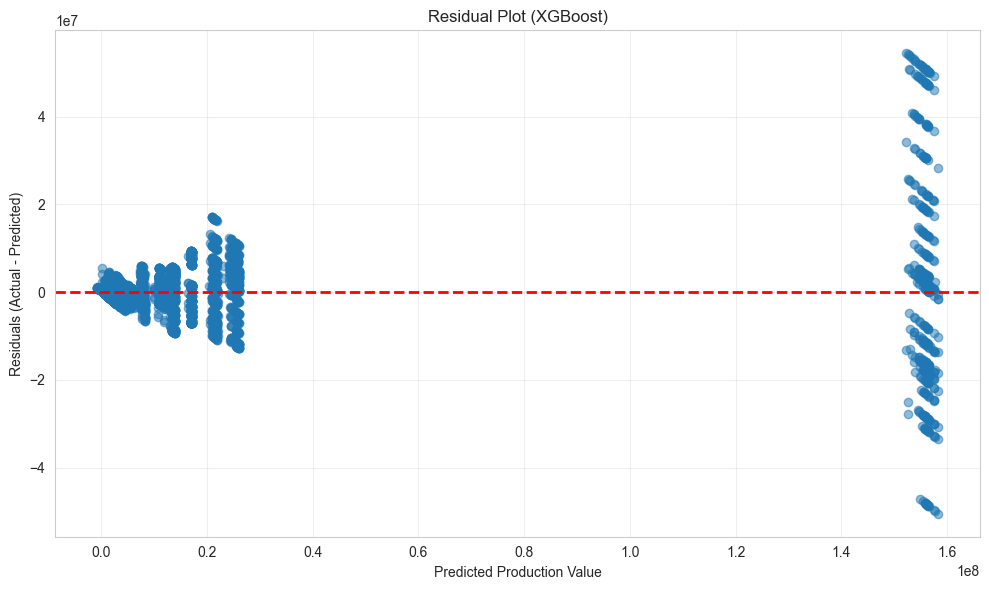

In [87]:
# Task 12: Visualization & Saving
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print(f"Best Model: {best_model_name}")
print(f"Training R²: {tuned_train_r2:.4f} ({tuned_train_r2*100:.2f}%) | MAE: {tuned_train_mae:.2f} | RMSE: {tuned_train_rmse:.2f}")
print(f"Testing R²:  {tuned_test_r2:.4f} ({tuned_test_r2*100:.2f}%) | MAE: {tuned_test_mae:.2f} | RMSE: {tuned_test_rmse:.2f}")

joblib.dump(final_model, 'best_yield_model.pkl')
joblib.dump(le, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\nModel, encoder, and scaler saved successfully.")

# Feature importance
if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
else:
    importances = np.abs(final_model.coef_)

feature_df = pd.DataFrame({
    'Feature': X.columns, 
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis', hue='Feature', legend=False)
plt.title(f'Feature Importance ({best_model_name})', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Prediction vs Actual Plot (Regression visualization)
test_pred = final_model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Production Value')
plt.ylabel('Predicted Production Value')
plt.title(f'Predicted vs Actual Production ({best_model_name})')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Residual Plot
residuals = y_test - test_pred
plt.figure(figsize=(10, 6))
plt.scatter(test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Production Value')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'Residual Plot ({best_model_name})')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [88]:
# Task 13: Model Testing
import pandas as pd
import numpy as np

rice_label_encoded = le.transform(['rice'])[0]
input_1 = pd.DataFrame([[90, 42, 43, 20.8, 82.0, 6.5, 202.9, rice_label_encoded]], columns=X.columns)

cotton_label_encoded = le.transform(['cotton'])[0]
input_2 = pd.DataFrame([[20, 40, 20, 25.0, 40.0, 7.0, 30.0, cotton_label_encoded]], columns=X.columns)

input_1_scaled = input_1.copy()
input_2_scaled = input_2.copy()
input_1_scaled[numeric_cols] = scaler.transform(input_1[numeric_cols])
input_2_scaled[numeric_cols] = scaler.transform(input_2[numeric_cols])

pred_1 = final_model.predict(input_1_scaled)[0]
pred_2 = final_model.predict(input_2_scaled)[0]

print("Test Case 1 (Rice - High Rain):")
print(f"  Predicted Production: {pred_1:,.2f} tons")
print("\nTest Case 2 (Cotton - Dry Land):")
print(f"  Predicted Production: {pred_2:,.2f} tons")

Test Case 1 (Rice - High Rain):
  Predicted Production: 154,708,432.00 tons

Test Case 2 (Cotton - Dry Land):
  Predicted Production: 4,161,155.00 tons
